In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Diffusity

┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [41]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 24    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [42]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

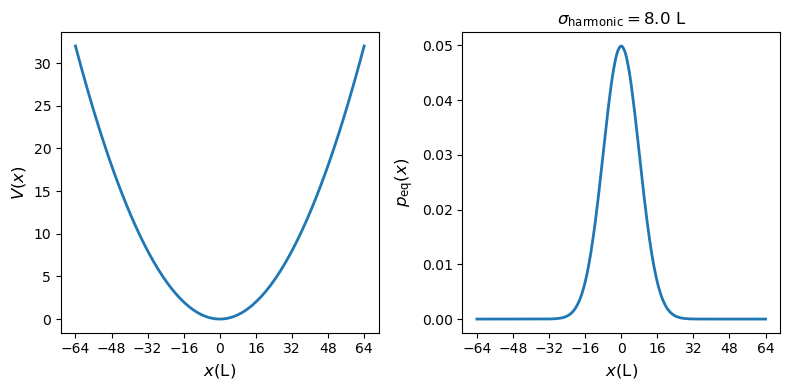

In [221]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [43]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [44]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

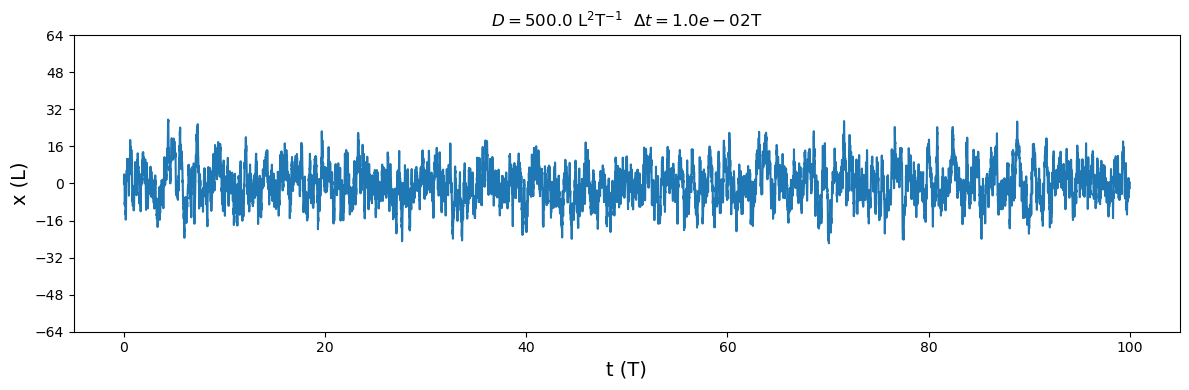

In [193]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get eigenvector and eigenvalues when $D=1$

In [45]:
D_unity = 1e0
eigenvalues_prime, eigenvect_mat_prime, rho_eq_by_fem_prime = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_unity, Nv)
weight_Qx_prime = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime);

### Part 5: Set Photon $\sigma$

In [46]:
σ_delta = 8.0
k_delta = get_k_by_sigma(σ_delta);

### Part 6: Set $D_{\text{guess}}$

In [61]:
D_guess = ones(Nv)
D_guess = 500 * D_guess;

In [86]:
save_freq_test = 1 * save_freq

0.01

### Part 7: Forward Backward

In [87]:
alpha_mat, beta_mat, Anorm_vec, r_sqrt_array = Diffusity.forward_backward_v0(Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, 
    xref, e_norm, interpo_xs, Np, k_delta, D_guess, eigenvalues_prime, save_freq_test);

### Part 8: get all $\xi(\textbf{s}_{n-1}, \textbf{s}_{n})$

In [88]:
xi_store_mat = Diffusity.get_xi_store_mat(Nv, tau, D_guess, eigenvalues_prime, save_freq_test, alpha_mat, y_record, xref, e_norm, 
    interpo_xs, Np, w0, k_delta, eigenvect_mat_prime, beta_mat);

### Part 9-1: Get Transition Matrix A

In [89]:
A_mat = Diffusity.get_A_mat(Nv, xi_store_mat, tau)

24×24 Transpose{Float64,Array{Float64,2}}:
 0.896849     0.712702     0.762085     …  0.831591     0.833511
 0.0790249    0.246715     0.204178        0.130703     0.129468
 1.02801e-15  2.59671e-15  2.68579e-15     1.505e-15    1.47211e-15
 7.8023e-16   1.77376e-15  1.0909e-15      1.09223e-15  1.10716e-15
 0.017101     0.0287       0.0229842       0.028129     0.0278333
 0.00475883   0.00828114   0.0075653    …  0.00674101   0.00640877
 0.00149994   0.00239201   0.0021075       0.00185426   0.00180826
 0.000485722  0.000771218  0.000683571     0.000612498  0.000622203
 0.000180152  0.000285337  0.000258313     0.000247199  0.000224769
 6.24913e-5   9.60094e-5   8.58194e-5      7.52412e-5   7.72985e-5
 2.44293e-5   3.61891e-5   3.30263e-5   …  2.99137e-5   2.96057e-5
 8.79432e-6   1.38579e-5   1.24849e-5      1.12674e-5   1.11896e-5
 2.80267e-6   4.00645e-6   3.6856e-6       3.33352e-6   3.37496e-6
 5.83936e-7   8.996e-7     8.11456e-7      7.1458e-7    7.20391e-7
 3.68779e-7   5.3608

In [90]:
sele_col_id = 24
sum(A_mat[:,sele_col_id])

0.9999999999999998

### Part 9-2: The first row of transition matrix

In [91]:
A_first_row = Diffusity.get_A_first_column(Nv, xi_store_mat, tau);

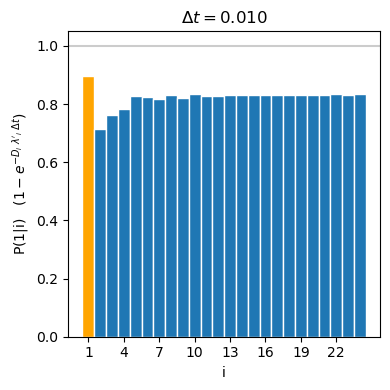

In [92]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

xarray = 1:Nv
xticks = 1:3:Nv
ax.bar(xarray[1], A_first_row[1], 1, color="orange", edgecolor="white")
ax.bar(xarray[2:end], A_first_row[2:end], 1, edgecolor="white")
ax.set_xticks(xticks)
ax.set_ylabel("P(1|i)   (\$1-e^{-D_i~\\lambda'_i~\\Delta t}\$)")
ax.set_xlabel("i")
ax.axhline(1, color="grey", alpha=0.4)
title = @sprintf "\$\\Delta t=%.3f\$" save_freq_test
ax.set_title(title)

plt.tight_layout()
plt.savefig("/home/yizaochen/Desktop/drawzone_temp/A_deltat_1.svg")
plt.show()

### Part 12: EM Iteration

In [93]:
D_guess = ones(Nv)
D_guess = 500 * D_guess;

In [94]:
n_iter = 20
D_em_mat, log_l_mat = Diffusity.EM_D_by_transition_matrix(n_iter, Nv, tau, w0, p_eq, N, eigenvect_mat_prime, y_record, xref, 
    e_norm, interpo_xs, Np, k_delta, D_guess, eigenvalues_prime, save_freq_test);

Start EM-Step: 1
Start EM-Step: 2
Start EM-Step: 3
Start EM-Step: 4
Start EM-Step: 5
Start EM-Step: 6
Start EM-Step: 7
Start EM-Step: 8
Start EM-Step: 9
Start EM-Step: 10
Start EM-Step: 11
Start EM-Step: 12
Start EM-Step: 13
Start EM-Step: 14
Start EM-Step: 15
Start EM-Step: 16
Start EM-Step: 17
Start EM-Step: 18
Start EM-Step: 19
Start EM-Step: 20


In [101]:
sele_iter_id = 15
D_em_mat[sele_iter_id,:]

24-element Array{Float64,1}:
     1.0
 89973.40891093419
 69079.85512830682
 69525.64517954703
 47387.45673764732
 31327.679955686664
 23233.453849611295
 18811.74219236069
 15578.721934768779
 13391.389226863228
 11691.175610418513
 10425.338358193001
  9422.581313048888
  8819.361457112069
  8417.717520295979
  7908.891032217814
  7263.730533866838
  6598.550380512009
  6016.361592022796
  5481.362692032066
  5006.456262238394
  4593.209803121654
  4221.831793552926
  3893.0516058602075

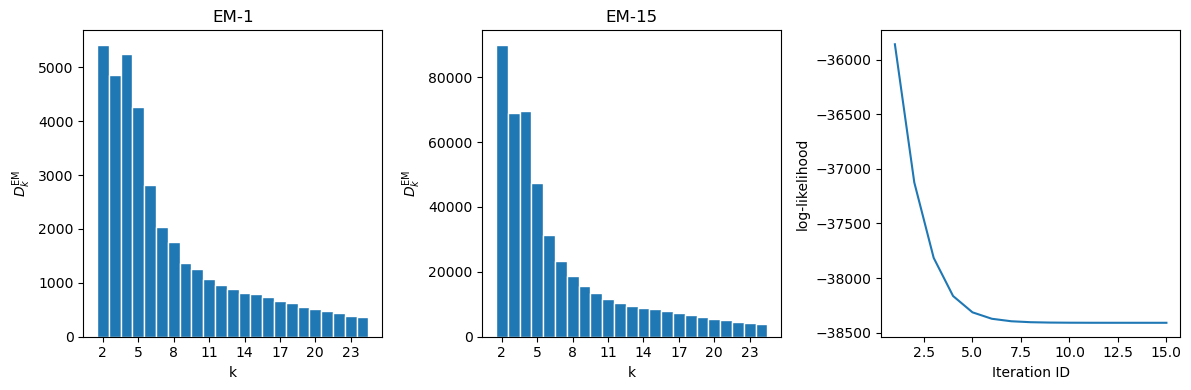

In [118]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
x_array = 2:Nv
y_array = D_em_mat[1,2:end]
xticks = 2:3:Nv
ax.bar(x_array, y_array, 1, edgecolor="white")
ax.set_xticks(xticks)
ax.set_ylabel("\$D^{\\mathrm{EM}}_k\$")
ax.set_xlabel("k")
title = "EM-1"
ax.set_title(title)

ax = axes[2]
x_array = 2:Nv
y_array = D_em_mat[15,2:end]
xticks = 2:3:Nv
ax.bar(x_array, y_array, 1, edgecolor="white")
ax.set_xticks(xticks)
ax.set_ylabel("\$D^{\\mathrm{EM}}_k\$")
ax.set_xlabel("k")
title = "EM-15"
ax.set_title(title)

ax = axes[3]
ax.plot(1:15, log_l_mat[1:15])
ax.set_xlabel("Iteration ID")
ax.set_ylabel("log-likelihood")

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/EM_D_result_1.pdf")
plt.show()

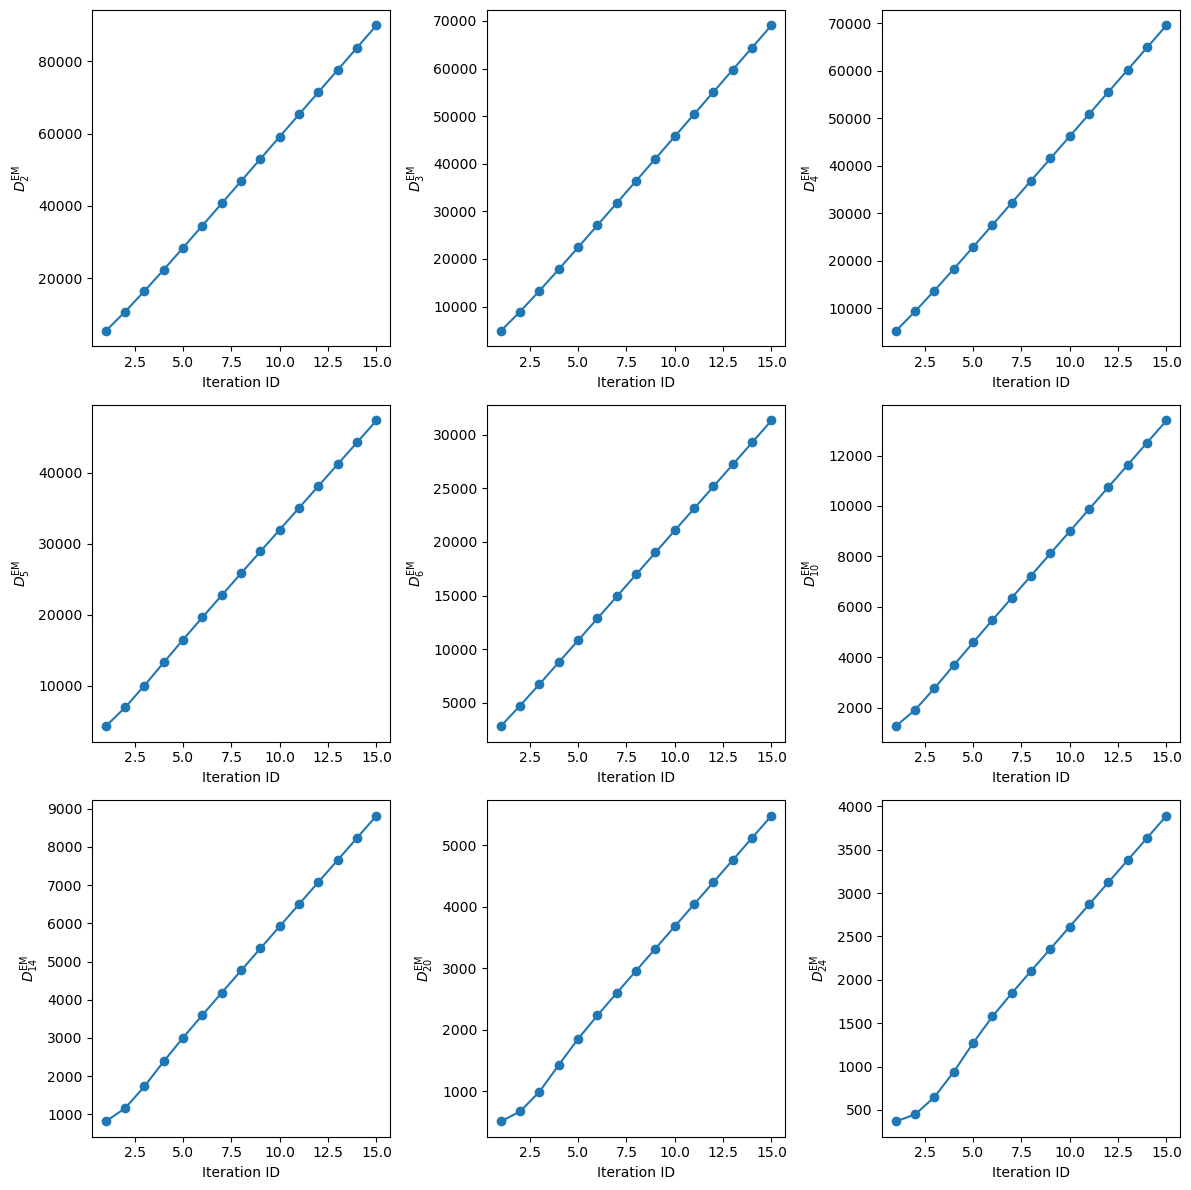

In [117]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12,12))

eigv_idx_array = [2, 3, 4, 5, 6, 10, 14, 20, 24] 
idx = 1
for row_id=1:3
    for col_id=1:3
        sele_eigv_idx = eigv_idx_array[idx]
        ax = axes[row_id,col_id]
        ax.plot(1:15, D_em_mat[1:15,sele_eigv_idx], "-o")
        ax.set_xlabel("Iteration ID")
        ax.set_ylabel(@sprintf "\$D^{\\mathrm{EM}}_{%d}\$" sele_eigv_idx)
        idx += 1
    end
end

plt.tight_layout()
#plt.savefig("/home/ytcdata/em_theory/Pictures/ch8/EM_D_result_2.pdf")
plt.show()